In [27]:
import pandas as pd

# 读取 CSV 文件
df = pd.read_csv("dataset.csv")

# 根据指定字段进行去重
df_unique = df.drop_duplicates(subset=["rsrp", "rsrq", "snr", "rat", "CID"])

# 将去重后的数据保存到新的 CSV 文件
df_unique.to_csv("refine_dataset.csv", index=False)

In [29]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [31]:
# 1. 数据准备与预处理

# 加载数据
data = pd.read_csv("refine_dataset.csv")

# 数据探索 (查看 ispoor 分布)
print(data['ispoor'].value_counts())

print("原始有效数据:")
print(data.head(3))
print(data.tail(3))

# 特征工程
# 数值特征标准化
numerical_features = ['rsrp', 'rsrq', 'snr']
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features]) # z-score标准化

print("z-score标准化数据:")
print(data.head(3))
print(data.tail(3))

# 分类特征独热编码
categorical_features = ['rat', 'CID']
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)  # drop_first=True 避免共线性 A + B = 1

print("独热编码数据:")
print(data.head(3))
print(data.tail(3))

ispoor
0    1238
1      49
Name: count, dtype: int64
原始有效数据:
   rsrp  rsrq  snr  rat  CID  ispoor
0   -93   -12    1    1    1       0
1   -86    -6   11    1    0       0
2   -70    -6   30    1    0       0
      rsrp  rsrq  snr  rat  CID  ispoor
1284   -94   -11   26    0    0       0
1285   -84   -11   30    0    0       0
1286  -117   -11    8    1    0       1
z-score标准化数据:
       rsrp      rsrq       snr  rat  CID  ispoor
0 -0.426389 -0.349468 -1.437763    1    1       0
1  0.195086  0.353657 -0.649688    1    0       0
2  1.615600  0.353657  0.847656    1    0       0
          rsrp      rsrq       snr  rat  CID  ispoor
1284 -0.515171 -0.232281  0.532425    0    0       0
1285  0.372650 -0.232281  0.847656    0    0       0
1286 -2.557160 -0.232281 -0.886110    1    0       1
独热编码数据:
       rsrp      rsrq       snr  ispoor  rat_1  CID_1
0 -0.426389 -0.349468 -1.437763       0   True   True
1  0.195086  0.353657 -0.649688       0   True  False
2  1.615600  0.353657  0.847656    

In [33]:
# 划分 X 和 y
X = data.drop('ispoor', axis=1).values
y = data['ispoor'].values

In [35]:
print(X.shape)
print(data.head(3))
print(X[:3])
print(y[:3])

(1287, 5)
       rsrp      rsrq       snr  ispoor  rat_1  CID_1
0 -0.426389 -0.349468 -1.437763       0   True   True
1  0.195086  0.353657 -0.649688       0   True  False
2  1.615600  0.353657  0.847656       0   True  False
[[-0.4263888168316355 -0.3494680369255108 -1.4377631070072814 True True]
 [0.19508616308038604 0.3536565543039823 -0.6496876731408542 True False]
 [1.6156004028792923 0.3536565543039823 0.8476556512053576 True False]]
[0 0 0]


In [37]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  # stratify=y 保持类别比例

# 检查并转换数据类型
print("X_train dtypes before conversion:\n", X_train.dtype)
print("X_test dtypes before conversion:\n", X_test.dtype)


# 转换数据类型为 float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)


print("X_train dtypes after conversion:\n", X_train.dtype)
print("X_test dtypes after conversion:\n", X_test.dtype)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print(X_train[:3])

X_train dtypes before conversion:
 object
X_test dtypes before conversion:
 object
X_train dtypes after conversion:
 float32
X_test dtypes after conversion:
 float32
Shape of X_train: (1029, 5)
Shape of X_test: (258, 5)
[[ 0.9941254   0.11928169  0.84765565  1.          0.        ]
 [ 0.10630402 -0.34946802 -0.96491784  1.          0.        ]
 [ 0.01752188  0.00209426 -0.09803487  1.          0.        ]]


In [39]:
# 2. 构建 Softmax 神经网络模型 (PyTorch)

class SoftmaxClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes=2):
        super(SoftmaxClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        # Softmax is implicitly included in CrossEntropyLoss

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# 3. 模型训练 (PyTorch)

# 超参数
input_size = X_train.shape[1]
hidden_size = 20  # 可调整
learning_rate = 0.001
batch_size = 32
num_epochs = 50
use_weighted_loss = True  # 选择是否使用加权损失

In [41]:
# 数据加载器 pytorch要求必须为浮点数
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                               torch.tensor(y_train, dtype=torch.long))  # CrossEntropyLoss expects Long type for target
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                              torch.tensor(y_test, dtype=torch.long))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [43]:
# 损失函数
if use_weighted_loss:
    # 计算类别权重
    class_counts = np.bincount(y_train)
    total_samples = len(y_train)
    class_weights = total_samples / (class_counts * 2)  # 2 classes (0 and 1)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    print(f'class_weights is {class_weights}')
else:
    criterion = nn.CrossEntropyLoss()  # 或 nn.BCEWithLogitsLoss() 如果输出层不使用softmax

# 优化器
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model = SoftmaxClassifier(input_size, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

class_weights is tensor([ 0.5197, 13.1923])


Fold 1
Epoch 1/50, Train Loss: 0.6359, Train Acc: 0.5249, Val Loss: 0.5638, Val Acc: 0.6505
Epoch 2/50, Train Loss: 0.5803, Train Acc: 0.6428, Val Loss: 0.5163, Val Acc: 0.7330
Epoch 3/50, Train Loss: 0.5236, Train Acc: 0.7363, Val Loss: 0.4723, Val Acc: 0.8010
Epoch 4/50, Train Loss: 0.4754, Train Acc: 0.7813, Val Loss: 0.4250, Val Acc: 0.8350
Epoch 5/50, Train Loss: 0.4309, Train Acc: 0.8117, Val Loss: 0.3898, Val Acc: 0.8495
Epoch 6/50, Train Loss: 0.3888, Train Acc: 0.8433, Val Loss: 0.3557, Val Acc: 0.8786
Epoch 7/50, Train Loss: 0.3616, Train Acc: 0.8518, Val Loss: 0.3247, Val Acc: 0.9029
Epoch 8/50, Train Loss: 0.3415, Train Acc: 0.8700, Val Loss: 0.3010, Val Acc: 0.9078
Epoch 9/50, Train Loss: 0.3093, Train Acc: 0.8821, Val Loss: 0.2753, Val Acc: 0.9126
Epoch 10/50, Train Loss: 0.2842, Train Acc: 0.8894, Val Loss: 0.2593, Val Acc: 0.9223
Epoch 11/50, Train Loss: 0.2649, Train Acc: 0.8979, Val Loss: 0.2423, Val Acc: 0.9223
Epoch 12/50, Train Loss: 0.2554, Train Acc: 0.9028, Val 

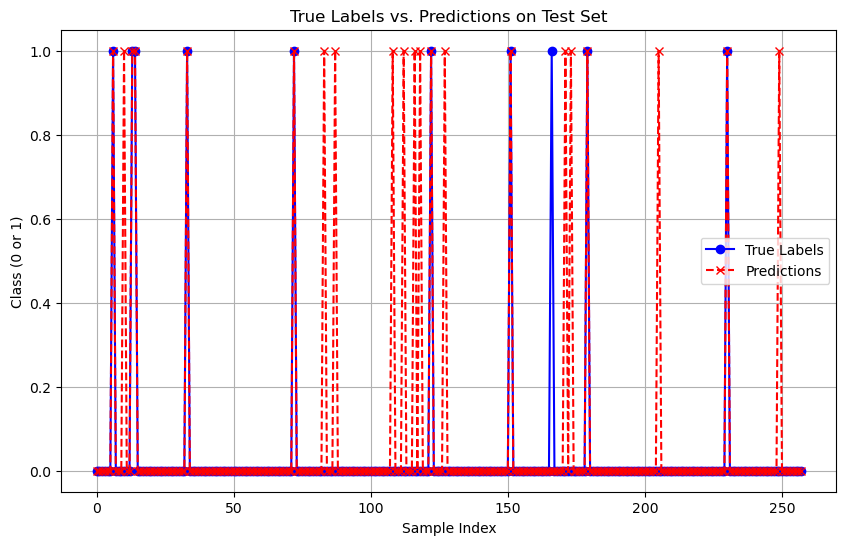

In [65]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
cv_losses = [] # 存储每一个fold的平均loss

for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f"Fold {fold + 1}")
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # 为每个折叠创建数据加载器
    train_fold_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train_fold, dtype=torch.float32),
                                                        torch.tensor(y_train_fold, dtype=torch.long))
    train_fold_loader = torch.utils.data.DataLoader(train_fold_dataset, batch_size=batch_size, shuffle=True)

    val_fold_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val_fold, dtype=torch.float32),
                                                      torch.tensor(y_val_fold, dtype=torch.long))
    val_fold_loader = torch.utils.data.DataLoader(val_fold_dataset, batch_size=batch_size, shuffle=False)

    # 重新初始化模型和优化器
    model = SoftmaxClassifier(input_size, hidden_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 训练循环
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_fold_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss = train_loss / train_total
        train_accuracy = train_correct / train_total

        # 验证
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_fold_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / val_total
        val_accuracy = val_correct / val_total

        cv_losses.append(val_loss) #将每个epoch的val_loss进行存储
        cv_scores.append(val_accuracy)


        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")


print(f"Cross-validation Accuracy: {np.mean(cv_scores):.4f} +/- {np.std(cv_scores):.4f}")
print(f"Cross-validation Loss: {np.mean(cv_losses):.4f} +/- {np.std(cv_losses):.4f}") # 打印loss
print("------------K-fold is done------------") # 打印loss

# 模块6. 在整个训练集上训练最终模型
model = SoftmaxClassifier(input_size, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


# 模块7. 评估 (测试集)
# ... 推理阶段 ...
model.eval()
with torch.no_grad():
    test_predictions = []
    test_labels = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_predictions.extend(predicted.cpu().numpy())  # 将预测结果移回 CPU
        test_labels.extend(labels.cpu().numpy()) # 将标签移回cpu

accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# 绘制对比图
plt.figure(figsize=(10, 6))  # 设置图形大小
plt.plot(test_labels, label='True Labels', marker='o', linestyle='-', color='blue')
plt.plot(test_predictions, label='Predictions', marker='x', linestyle='--', color='red')
plt.xlabel('Sample Index')
plt.ylabel('Class (0 or 1)')
plt.title('True Labels vs. Predictions on Test Set')
plt.legend()
plt.grid(True)
plt.show()

ispoor
0    1238
1      49
Name: count, dtype: int64
Fold 1
Epoch 1/50, Train Loss: 0.7643, Train Acc: 0.6671, Val Loss: 0.7266, Val Acc: 0.6165
Epoch 2/50, Train Loss: 0.6989, Train Acc: 0.6634, Val Loss: 0.6431, Val Acc: 0.7379
Epoch 3/50, Train Loss: 0.6503, Train Acc: 0.7412, Val Loss: 0.5971, Val Acc: 0.8155
Epoch 4/50, Train Loss: 0.6020, Train Acc: 0.7861, Val Loss: 0.5571, Val Acc: 0.8544
Epoch 5/50, Train Loss: 0.5585, Train Acc: 0.8190, Val Loss: 0.5138, Val Acc: 0.8689
Epoch 6/50, Train Loss: 0.5097, Train Acc: 0.8165, Val Loss: 0.4693, Val Acc: 0.8398
Epoch 7/50, Train Loss: 0.4792, Train Acc: 0.8141, Val Loss: 0.4305, Val Acc: 0.8398
Epoch 8/50, Train Loss: 0.4394, Train Acc: 0.8518, Val Loss: 0.4000, Val Acc: 0.8786
Epoch 9/50, Train Loss: 0.4001, Train Acc: 0.8676, Val Loss: 0.3671, Val Acc: 0.8883
Epoch 10/50, Train Loss: 0.3627, Train Acc: 0.8663, Val Loss: 0.3380, Val Acc: 0.8786
Epoch 11/50, Train Loss: 0.3454, Train Acc: 0.8724, Val Loss: 0.3151, Val Acc: 0.8932
Epo

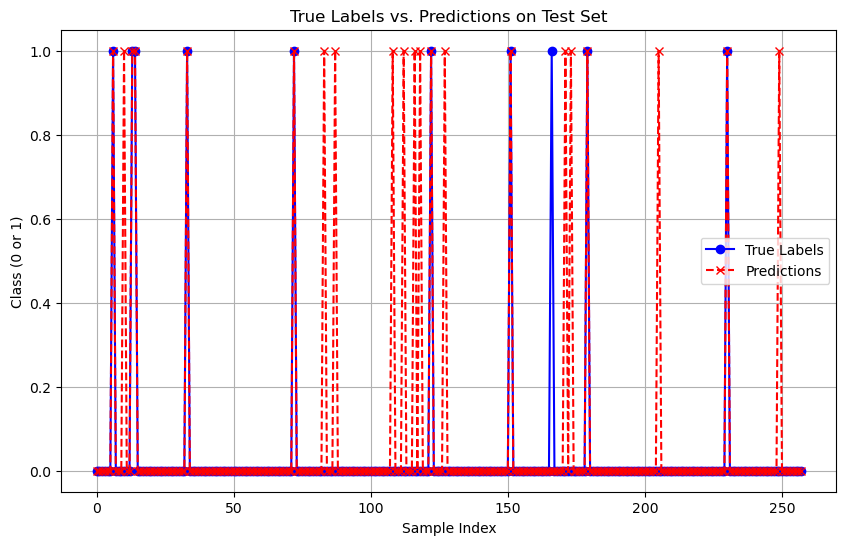

In [63]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt 

# 模块1. 数据准备与预处理

# 读取 CSV 文件
df = pd.read_csv("dataset.csv")

# 根据指定字段进行去重
df_unique = df.drop_duplicates(subset=["rsrp", "rsrq", "snr", "rat", "CID"])

# 将去重后的数据保存到新的 CSV 文件
df_unique.to_csv("refine_dataset.csv", index=False)

# 加载数据
data = pd.read_csv("refine_dataset.csv")

# 数据探索 (查看 ispoor 分布)
print(data['ispoor'].value_counts())

# 特征工程
# 数值特征标准化
numerical_features = ['rsrp', 'rsrq', 'snr']
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# 分类特征独热编码
categorical_features = ['rat', 'CID']
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

# 划分 X 和 y
X = data.drop('ispoor', axis=1).values
y = data['ispoor'].values

# 划分训练集和测试集 80%用于训练
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 数据类型转换
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.int64)  # 明确转换为 int64
y_test = y_test.astype(np.int64)    # 明确转换为 int64

# 模块2. 构建 Softmax 神经网络模型 (PyTorch)
# ... (SoftmaxClassifier 类) ...
class SoftmaxClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes=2):
        super(SoftmaxClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        # Softmax is implicitly included in CrossEntropyLoss

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


# 模块3. 模型训练参数准备

# 超参数
input_size = X_train.shape[1]
hidden_size = 20
learning_rate = 0.001
batch_size = 32
num_epochs = 50
use_weighted_loss = True

# 设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# 数据加载器 (确保标签类型为 long)
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                               torch.tensor(y_train, dtype=torch.long))  # 确保是 long
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                              torch.tensor(y_test, dtype=torch.long))   # 确保是 long
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 损失函数
if use_weighted_loss:
    class_counts = np.bincount(y_train)
    total_samples = len(y_train)
    class_weights = total_samples / (class_counts * 2)
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)  # 移动到 MPS
    criterion = nn.CrossEntropyLoss(weight=class_weights)
else:
    criterion = nn.CrossEntropyLoss()

# 优化器
model = SoftmaxClassifier(input_size, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 模块4. K折交叉验证 k=5
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
cv_losses = [] # 存储每一个fold的平均loss

for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f"Fold {fold + 1}")
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # 为每个折叠创建数据加载器
    train_fold_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train_fold, dtype=torch.float32),
                                                        torch.tensor(y_train_fold, dtype=torch.long))
    train_fold_loader = torch.utils.data.DataLoader(train_fold_dataset, batch_size=batch_size, shuffle=True)

    val_fold_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val_fold, dtype=torch.float32),
                                                      torch.tensor(y_val_fold, dtype=torch.long))
    val_fold_loader = torch.utils.data.DataLoader(val_fold_dataset, batch_size=batch_size, shuffle=False)

    # 重新初始化模型和优化器
    model = SoftmaxClassifier(input_size, hidden_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 训练循环
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_fold_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss = train_loss / train_total
        train_accuracy = train_correct / train_total

        # 验证
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_fold_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / val_total
        val_accuracy = val_correct / val_total

        cv_losses.append(val_loss) #将每个epoch的val_loss进行存储
        cv_scores.append(val_accuracy)


        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")


print(f"Cross-validation Accuracy: {np.mean(cv_scores):.4f} +/- {np.std(cv_scores):.4f}")
print(f"Cross-validation Loss: {np.mean(cv_losses):.4f} +/- {np.std(cv_losses):.4f}") # 打印loss
print("------------K-fold is done------------") # 打印loss

# 模块6. 在整个训练集上训练最终模型
model = SoftmaxClassifier(input_size, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


# 模块7. 评估 (测试集)
# ... 推理阶段 ...
model.eval()
with torch.no_grad():
    test_predictions = []
    test_labels = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_predictions.extend(predicted.cpu().numpy())  # 将预测结果移回 CPU
        test_labels.extend(labels.cpu().numpy()) # 将标签移回cpu

accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# 绘制对比图
plt.figure(figsize=(10, 6))  # 设置图形大小
plt.plot(test_labels, label='True Labels', marker='o', linestyle='-', color='blue')
plt.plot(test_predictions, label='Predictions', marker='x', linestyle='--', color='red')
plt.xlabel('Sample Index')
plt.ylabel('Class (0 or 1)')
plt.title('True Labels vs. Predictions on Test Set')
plt.legend()
plt.grid(True)
plt.show()